In [1]:
import bnlearn as bn
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
def convert_onehot(df,verbose = 0):
    #function to transform the data to numerical values.
    dfhot, dfnum = bn.df2onehot(df,verbose = verbose)
    return dfhot,dfnum
def generate_dag(df,indepence_test= True,verbose = 0):
    #learn the edge between the nodes
    # if independence test is true quit some edges from the graph
    #model = bn.structure_learning.fit(dfnum, methodtype='cl', black_list=['Embarked','Parch','Name'], root_node='Survived', bw_list_method='nodes')
    #model = bn.structure_learning.fit(df, methodtype='hc', scoretype='bic',root_node='Survived',verbose= verbose)
    model = bn.structure_learning.fit(df,verbose= verbose)
    if indepence_test:
        model = bn.independence_test(model, df, test='chi_square', prune=True,verbose= verbose)
    return model
def learn_cpd(model,dfnum,verbose = 0):
    # extract the probabilities.
    model = bn.parameter_learning.fit(model, dfnum,verbose= verbose)
    return model
def create_dag(dag_info,cpd = None ,verbose = 0):
    #change cpds
    model = bn.make_DAG(dag_info, CPD=cpd,verbose= verbose)
    return model
def get_dataset(model,n_samples = 1000, methodtype = 'bayes',verbose =  0):
    df = bn.sampling(model, n= n_samples, methodtype = methodtype, verbose = verbose)
    return df

In [2]:
# Load example mixed dataset
df = bn.import_example(data='titanic')

[bnlearn] >Downloading example [titanic_train] dataset..
100% [..............................................................................] 22510 / 22510[bnlearn] >Import dataset..


In [3]:
# Convert to onehot
dfhot, dfnum = convert_onehot(df)

In [209]:
dfnum

,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Cabin,Embarked
0,0,3,108,1,2,1,523,146,3
1,1,1,190,0,2,1,596,81,1
2,1,3,353,0,1,1,669,146,3
3,1,1,272,0,2,1,49,55,3
4,0,3,15,1,1,1,472,146,3
...,...,...,...,...,...,...,...,...,...
886,0,2,548,1,1,1,101,146,3
887,1,1,303,0,1,1,14,30,3
888,0,3,413,0,2,3,675,146,3
889,1,1,81,1,1,1,8,60,1


## Generate DAG

In [210]:
model = generate_dag(dfnum,True)

[bnlearn] >Compute structure scores ['k2', 'bds', 'bic', 'bdeu'] for model comparison (higher is better).


[bnlearn] >Set node properties.
[bnlearn]> Set edge weights based on the [chi_square] test statistic.
[bnlearn] >Set edge properties.
[bnlearn] >Plot based on Bayesian model


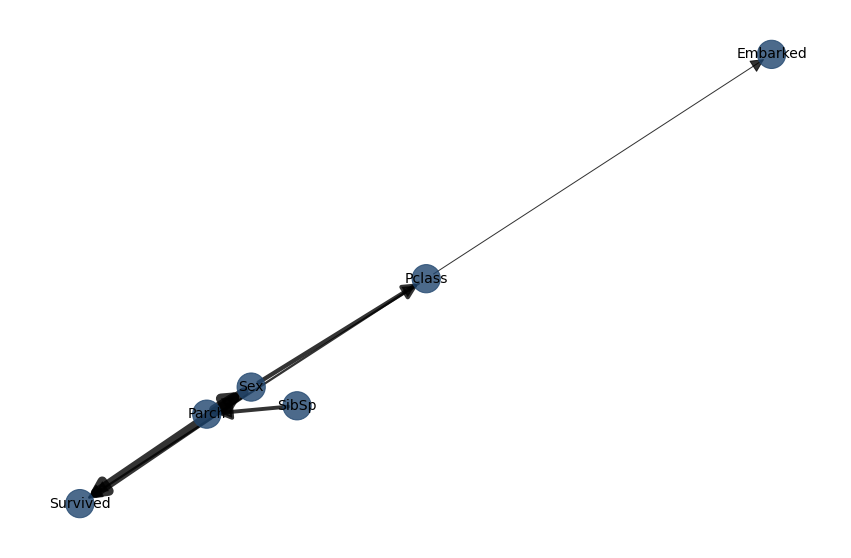

{'pos': {'Survived': array([-0.61474531, -0.55938788]),
  'Pclass': array([ 0.1938675 , -0.01357934]),
  'Name': array([-0.51255999,  0.77237449]),
  'Sex': array([-0.21475421, -0.27655908]),
  'SibSp': array([-0.1076877 , -0.32197999]),
  'Parch': array([-0.31849474, -0.34226809]),
  'Ticket': array([0.26487413, 0.97890281]),
  'Cabin': array([ 0.30950031, -0.76828757]),
  'Embarked': array([1.        , 0.53078464])},
 'G': <networkx.classes.digraph.DiGraph at 0x7fd6f24eeb20>,
 'node_properties': {'Survived': {'node_color': '#1f456e', 'node_size': 800},
  'Pclass': {'node_color': '#1f456e', 'node_size': 800},
  'Name': {'node_color': '#1f456e', 'node_size': 800},
  'Sex': {'node_color': '#1f456e', 'node_size': 800},
  'SibSp': {'node_color': '#1f456e', 'node_size': 800},
  'Parch': {'node_color': '#1f456e', 'node_size': 800},
  'Ticket': {'node_color': '#1f456e', 'node_size': 800},
  'Cabin': {'node_color': '#1f456e', 'node_size': 800},
  'Embarked': {'node_color': '#1f456e', 'node_si

In [211]:
bn.plot(model)


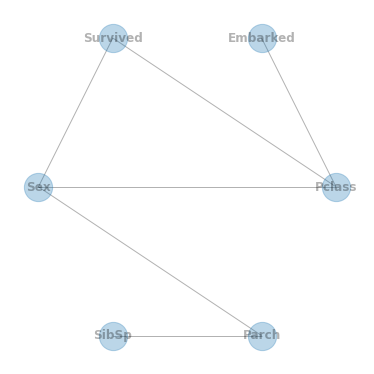

In [190]:
G = nx.Graph()
G.add_edges_from(model['model_edges'])
plt.figure(figsize=(5,5)) 
nx.draw_circular(
    G, with_labels=True, arrowsize=30, node_size=800, alpha=0.3, font_weight="bold"
)


In [191]:
model.keys()

dict_keys(['model', 'model_edges', 'adjmat', 'config', 'structure_scores', 'independence_test'])

In [192]:
model['structure_scores']

{'k2': -18119.21450812245,
 'bds': -22996.58044598527,
 'bic': -23045.855828721913,
 'bdeu': -22967.468264401752}

## Learn CDP

In [193]:
model = create_dag(model['model_edges'])

In [194]:
model = learn_cpd(model, dfnum)

[bnlearn] >Compute structure scores ['k2', 'bds', 'bic', 'bdeu'] for model comparison (higher is better).


In [195]:
#change cpds
model = change_cpd(list(model['model_edges']), model['model'].get_cpds())

In [200]:
list(model['model_edges'])

[('Pclass', 'Embarked'),
 ('Pclass', 'Survived'),
 ('Sex', 'Survived'),
 ('Sex', 'Pclass'),
 ('SibSp', 'Parch'),
 ('Parch', 'Sex')]

In [204]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [196]:
CPDs = bn.print_CPD(model,verbose = 0)

In [197]:
CPDs.keys()

dict_keys(['Pclass', 'Embarked', 'Survived', 'Sex', 'SibSp', 'Parch'])

In [198]:
CPDs['Survived']

,Survived,Pclass,Sex,p
0,0,0,0,0.331202
1,0,0,1,0.555427
2,0,1,0,0.368132
3,0,1,1,0.634709
4,0,2,0,0.500000
5,0,2,1,0.746269
6,1,0,0,0.668798
7,1,0,1,0.444573
8,1,1,0,0.631868
9,1,1,1,0.365291


## Get dataset

In [166]:
 df_result = get_dataset(model,891)

In [167]:
df_result

,Pclass,Survived,Embarked,Sex,SibSp,Parch
0,1,0,1,1,1,1
1,3,1,3,0,1,1
2,1,1,3,1,0,0
3,1,1,3,1,2,1
4,1,1,3,1,2,0
...,...,...,...,...,...,...
886,1,1,3,1,2,3
887,1,1,2,1,5,3
888,2,0,2,1,1,1
889,3,0,2,1,4,0


In [141]:
predict = bn.predict(model, df_result, variables=['Survived'])

[bnlearn]> Remaining columns for inference: 5



100%|████████████████████████████████████████████████████████████████████████████████| 576/576 [00:02<00:00, 271.41it/s]


In [142]:
predict.Survived.value_counts()

0    7321
1    2679
Name: Survived, dtype: int64

In [143]:
from sklearn.metrics import accuracy_score
accuracy_score(df_result.Survived,predict.Survived)

0.5782

In [144]:
df_result[0:1]

,Pclass,Survived,Embarked,Sex,SibSp,Parch
0,3,0,1,1,5,2


In [145]:
predict[0:1]

,Survived,p
0,0,0.746269


In [146]:
bn.inference.fit(model, variables=['Survived'], evidence={'Pclass':3,
                                                          'Embarked':1,
                                                          'Sex':1,
                                                          'SibSp':5,
                                                          'Parch':2})


[bnlearn] >Variable Elimination..


0it [00:00, ?it/s]

0it [00:00, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+------------+----------+
|    |   Survived |        p |
+====+============+==========+
|  0 |          0 | 0.746269 |
+----+------------+----------+
|  1 |          1 | 0.253731 |
+----+------------+----------+


<DiscreteFactor representing phi(Survived:2) at 0x7fd6ce6eab20>

In [159]:
from sklearn.metrics import accuracy_score
accuracy_score(df_result.loc[predict[predict.p > 0.7].index.values].Survived,predict[predict.p > 0.7].Survived)

0.6383531157270029

In [160]:
import pandas as pd

from sklearn import datasets

from evidently.dashboard import Dashboard
from evidently.dashboard.tabs import DataDriftTab, CatTargetDriftTab

from evidently.model_profile import Profile
from evidently.model_profile.sections import DataDriftProfileSection, CatTargetDriftProfileSection 

In [168]:
dashboard = Dashboard(tabs=[DataDriftTab(verbose_level=1)])

In [169]:
dashboard.calculate(dfnum[df_result.columns], df_result, column_mapping=None)


In [170]:
dashboard.save('dashboard_drift.html')

In [172]:
dfnum.Embarked.value_counts()

3    644
1    168
2     77
0      2
Name: Embarked, dtype: int64